<a href="https://colab.research.google.com/github/chloeahughes/Homelessness-in-California/blob/main/2_Data_Exploration_DATASCI112_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Exploration**
This Colab notebook focuses on analyzing trends in homelessness, educational attainment, housing costs, and other socioeconomic factors across counties in California. By integrating multiple datasets, we aim to uncover relationships between key variables and assess how different factors influence homelessness rates.
This notebook takes a data-driven approach to understanding the factors influencing homelessness by integrating multiple datasets, including demographics, housing costs, and political affiliations. Through **statistical analysis and visualizations**, we explore patterns in homelessness rates, identify key socioeconomic drivers, and assess regional disparities across California. The goal is to generate actionable insights that can inform **policy decisions, housing initiatives, and community support programs** to address homelessness more effectively.

import files

In [ ]:
import pandas as pd from google.colab
import drive import seaborn as sns
import matplotlib.pyplot as pltimport matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

import cleaned data

In [ ]:
#upload previously cleaned csv files

df_population = pd.read_csv('/content/county_pop.csv')
df_homeless = pd.read_csv('/content/county_homeless.csv')
df_race = pd.read_csv('/content/race_population_rates (1).csv')
df_voter = pd.read_csv('/content/county_vote.csv')
df_zhvi = pd.read_csv('/content/county_zhvi (3).csv')
df_zori = pd.read_csv('/content/county_zori.csv')
df_dropout = pd.read_csv('/content/county_drop.csv')


In [ ]:
#ensure the county column is standardized across all datasets
datasets = [df_dropout, df_homeless, df_population, df_voter, df_zhvi, df_zori]
for df in datasets:
    if "county" in df.columns:
        df["county"] = df["county"].astype(str).str.lower().str.strip()

# Merge the datasets on the "county" column using an outer join
df_merged = pd.merge(df_population, df_homeless, on="county", how="outer")
df_merged = pd.merge(df_merged, df_dropout, on="county", how="outer")
df_merged = pd.merge(df_merged, df_voter, on="county", how="outer")
df_merged = pd.merge(df_merged, df_zhvi, on="county", how="outer")
df_merged = pd.merge(df_merged, df_zori, on="county", how="outer")

df_merged.sort_values(by="county", inplace=True)

df_merged.to_csv("merged_california_county_data.csv", index=False)
explicit_columns = ["county",
    "total_population_2019",
    "Count of Sheltered Homeless",
    "Count of Unsheltered Homeless",
    "Count of Total Homeless",
    "Funding Amount",
    "Value (Percent)",         # dropout rate column
    "Total Registered",
    "Democratic",
    "Republican",
    "American Independent",
    "Libertarian",
    "Other"
]

additional_2019_columns = [col for col in df_merged.columns
                           if "2019" in col.lower() and col not in explicit_columns]

columns_to_keep = explicit_columns + additional_2019_columns
columns_to_keep = [col for col in columns_to_keep if "rank within us" not in col.lower()]

df_filtered = df_merged[columns_to_keep]
invalid_mask = pd.to_numeric(df_filtered["Count of Total Homeless"], errors="coerce").isna() & df_filtered["Count of Total Homeless"].notna()
df_filtered["Count of Total Homeless"] = (
    df_filtered["Count of Total Homeless"]
    .astype(str)
    .str.replace(",", "", regex=False)   # remove commas
    .str.replace("[^0-9.\-]", "", regex=True)  # keep only digits, decimal points, minus sign
)

# Then convert
df_filtered["Count of Total Homeless"] = pd.to_numeric(
    df_filtered["Count of Total Homeless"], errors="coerce"
)
df_filtered.dropna(subset=["Count of Total Homeless"], inplace=True)
mean_value = df_filtered["Count of Total Homeless"].mean()
df_filtered["Count of Total Homeless"].fillna(mean_value, inplace=True)
import pandas as pd

df_filtered["Count of Total Homeless"] = pd.to_numeric(
    df_filtered["Count of Total Homeless"], errors="coerce"
)
df_filtered["total_population_2019"] = pd.to_numeric(
    df_filtered["total_population_2019"], errors="coerce"
)

df_filtered["% homeless"] = (
    df_filtered["Count of Total Homeless"] / df_filtered["total_population_2019"] * 100
)
df_filtered.drop_duplicates(subset=["county"], keep="first", inplace=True)


<ipython-input-76-aa51a1ccc6da>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Count of Total Homeless"] = (
<ipython-input-76-aa51a1ccc6da>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Count of Total Homeless"] = pd.to_numeric(
<ipython-input-76-aa51a1ccc6da>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [ ]:
housing_months_zhvi = [
    "2019-01-31_x", "2019-02-28_x", "2019-03-31_x",
    "2019-04-30_x", "2019-05-31_x", "2019-06-30_x",
    "2019-07-31_x", "2019-08-31_x", "2019-09-30_x",
    "2019-10-31_x", "2019-11-30_x", "2019-12-31_x"
]
housing_months_zori = [
    "2019-01-31_y", "2019-02-28_y", "2019-03-31_y",
    "2019-04-30_y", "2019-05-31_y", "2019-06-30_y",
    "2019-07-31_y", "2019-08-31_y", "2019-09-30_y",
    "2019-10-31_y", "2019-11-30_y", "2019-12-31_y"
]
df_filtered["avg_housing_index_2019_zhvi"] = df_filtered[housing_months_zhvi].mean(axis=1)
df_filtered["avg_housing_index_2019_zori"] = df_filtered[housing_months_zori].mean(axis=1)

df_filtered["% homeless"] = (
    df_filtered["Count of Total Homeless"] / df_filtered["total_population_2019"] * 100
)

df_filtered.to_csv("updated_df_filtered.csv", index=False)


<ipython-input-95-609c80c46b8d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["avg_housing_index_2019_zhvi"] = df_filtered[housing_months_zhvi].mean(axis=1)
<ipython-input-95-609c80c46b8d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["avg_housing_index_2019_zori"] = df_filtered[housing_months_zori].mean(axis=1)
<ipython-input-95-609c80c46b8d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [ ]:
drive.mount('/content/drive')

In [ ]:
#RACE HEATMAP
file_path = "/content/race_population_rates.csv"
df_race = pd.read_csv(file_path)

race_columns = [col for col in df_race.columns if "People " in col]
df_race[race_columns] = df_race[race_columns].apply(pd.to_numeric, errors="coerce")
df_race.set_index("County", inplace=True)

plt.figure(figsize=(24, 16))
sns.heatmap(df_race[race_columns], cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)

plt.title("Rate by Race Across Counties in California", fontsize=14)
plt.xlabel("Race", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.show()


In [ ]:
file_path = "/content/race_population_rates.csv"
df = pd.read_csv(file_path)

population_columns = [col for col in df.columns if "People" in col]

df[population_columns] = df[population_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

highest_counts = []
for col in population_columns:
    max_index = df[col].idxmax()  # Get index of the max value
    highest_counts.append({
        "Race": col.replace("People_", ""),  # Clean up column name
        "County": df.loc[max_index, "County"],
        "Max_Count": df.loc[max_index, col]
    })
highest_counts_df = pd.DataFrame(highest_counts)
highest_counts_df

In [ ]:
homeless_df = pd.read_csv("cleaned_county_homeless.csv")
race_population_df = pd.read_csv("race_population_rates.csv")
homeless_df["Count of Total Homeless"] = homeless_df["Count of Total Homeless"].str.replace(",", "").astype(int)

homeless_agg = homeless_df.groupby("CoC Name")["Count of Total Homeless"].sum().reset_index()
homeless_agg.rename(columns={"CoC Name": "County", "Count of Total Homeless": "Total Homeless"}, inplace=True)
race_population_df["Total White"] = race_population_df["People (White)_White"]
race_population_df["Total Black"] = race_population_df["People (Black)_Black or African American"]
race_population_df["Total Hispanic"] = race_population_df["People (Hispanic)_Hispanic"]
race_population_df["Total API"] = race_population_df["People (API)_Asian, Native Hawaiian or Pacific Islander"]
race_population_df["Total AIAN"] = race_population_df["People (AI/AN)_American Indian or Alaska Native"]
race_population_df["Total Foreign Born"] = race_population_df["People (Foreign Born)_Foreign Born"]

# Mapping CoC Names to individual counties
coc_to_county = {
    "Alpine, Inyo, Mono Counties CoC": ["Alpine County", "Inyo County", "Mono County"],
    "Bakersfield/Kern County CoC": ["Kern County"],
    "Chico, Paradise/Butte County CoC": ["Butte County"],
    "Colusa, Glenn, Trinity Counties CoC": ["Colusa County", "Glenn County", "Trinity County"],
    "Daly City/San Mateo County CoC": ["San Mateo County"],
    "Davis, Woodland/Yolo County CoC": ["Yolo County"],
    "El Dorado County CoC": ["El Dorado County"],
    "Fresno City & County/Madera County CoC": ["Fresno County", "Madera County"],
    "Glendale CoC": ["Los Angeles County"],
    "Humboldt County CoC": ["Humboldt County"],
    "Imperial County CoC": ["Imperial County"],
    "Lake County CoC": ["Lake County"],
    "Long Beach CoC": ["Los Angeles County"],
    "Los Angeles City & County CoC": ["Los Angeles County"],
    "Marin County CoC": ["Marin County"],
    "Mendocino County CoC": ["Mendocino County"],
    "Merced City & County CoC": ["Merced County"],
    "Napa City & County CoC": ["Napa County"],
    "Nevada County CoC": ["Nevada County"],
    "Oakland, Berkeley/Alameda County CoC": ["Alameda County"],
    "Oxnard, San Buenaventura/Ventura County CoC": ["Ventura County"],
    "Pasadena CoC": ["Los Angeles County"],
    "Redding/Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC":
        ["Shasta County", "Siskiyou County", "Lassen County", "Plumas County", "Del Norte County", "Modoc County", "Sierra County"],
    "Richmond/Contra Costa County CoC": ["Contra Costa County"],
    "Riverside City & County CoC": ["Riverside County"],
    "Roseville, Rocklin/Placer County CoC": ["Placer County"],
    "Sacramento City & County CoC": ["Sacramento County"],
    "Salinas/Monterey, San Benito Counties CoC": ["Monterey County", "San Benito County"],
    "San Bernardino City & County CoC": ["San Bernardino County"],
    "San Diego City and County CoC": ["San Diego County"],
    "San Francisco CoC": ["San Francisco County"],
    "San José/Santa Clara City & County CoC": ["Santa Clara County"],
    "San Luis Obispo County CoC": ["San Luis Obispo County"],
    "Santa Ana, Anaheim/Orange County CoC": ["Orange County"],
    "Santa Maria/Santa Barbara County CoC": ["Santa Barbara County"],
    "Santa Rosa, Petaluma/Sonoma County CoC": ["Sonoma County"],
    "Stockton/San Joaquin County CoC": ["San Joaquin County"],
    "Tehama County CoC": ["Tehama County"],
    "Tuolumne, Amador, Calaveras, Mariposa Counties CoC": ["Tuolumne County", "Amador County", "Calaveras County", "Mariposa County"],
    "Turlock, Modesto/Stanislaus County CoC": ["Stanislaus County"],
    "Vallejo/Solano County CoC": ["Solano County"],
    "Visalia/Kings, Tulare Counties CoC": ["Kings County", "Tulare County"],
    "Watsonville/Santa Cruz City & County CoC": ["Santa Cruz County"],
    "Yuba City & County/Sutter County CoC": ["Sutter County", "Yuba County"]
}

expanded_homeless = []
for _, row in homeless_agg.iterrows():
    coc_name = row["County"]
    total_homeless = row["Total Homeless"]
    if coc_name in coc_to_county:
        for county in coc_to_county[coc_name]:
            expanded_homeless.append({"County": county, "Total Homeless": total_homeless})

homeless_expanded_df = pd.DataFrame(expanded_homeless)
merged_df = pd.merge(homeless_expanded_df, race_population_df, on="County", how="inner")

race_columns = ["Total White", "Total Black", "Total Hispanic", "Total API", "Total AIAN", "Total Foreign Born"]
for col in race_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

colors = ["blue", "black", "red", "green", "orange", "purple"]
race_labels = ["White", "Black", "Hispanic", "API", "AI/AN", "Foreign Born"]

plt.figure(figsize=(12, 7))

for race, color, label in zip(race_columns, colors, race_labels):
    plt.scatter(merged_df[race], merged_df["Total Homeless"], color=color, alpha=0.6, label=label)

plt.xlabel("Total Population of Race")
plt.xlim(0, 4000)
plt.ylabel("Total Homeless Population")
plt.ylim(0, 4000)  # exclude outlier for better visuals
plt.title("Race-Specific Population vs. Homeless Population by County")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
colors = ["blue", "black", "red", "green", "orange", "purple"]
race_labels = ["White", "Black", "Hispanic", "API", "AI/AN", "Foreign Born"]
race_columns = ["Total White", "Total Black", "Total Hispanic", "Total API", "Total AIAN", "Total Foreign Born"]

merged_df_sorted = merged_df.sort_values(by="Total Homeless")

plt.figure(figsize=(12, 7))

for race, color, label in zip(race_columns, colors, race_labels):
    plt.plot(
        merged_df_sorted["Total Homeless"],
        merged_df_sorted[race],
        marker="o", linestyle="-", color=color, label=label, alpha=0.7
    )

plt.xlabel("Total Homeless Population")
plt.ylabel("Total Population of Race")
plt.title("Trends in Race-Specific Populations vs. Homelessness")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()



In [ ]:
race_columns = ["People (White)_White", "People (Black)_Black or African American", "Value (Percent)_Hispanic", "Value (Percent)_Asian, Native Hawaiian or Pacific Islander", "People (AI/AN)_American Indian or Alaska Native", "People (Foreign Born)_Foreign Born"]
dominant_race = merged_df[race_columns].idxmax(axis=1)  # Find column with highest population
merged_df["Dominant Race"] = dominant_race

#define color mapping for dominant races
color_map = {
    "Total White": "blue",
    "Total Black": "black",
    "Total Hispanic": "red",
    "Total API": "green",
    "Total AIAN": "orange",
    "Total Foreign Born": "purple"
}

merged_df["Color"] = merged_df["Dominant Race"].map(color_map)

plt.figure(figsize=(12, 7))
plt.scatter(merged_df["Total_Population"], merged_df["Total Homeless"],  color=merged_df["Color"], alpha=0.6, edgecolors="k")

#annotate with county names
for i, txt in enumerate(merged_df["County"]):
    plt.annotate(txt, (merged_df["People "].iloc[i], merged_df["Total Homeless"].iloc[i]),
                 fontsize=8, alpha=0.7, textcoords="offset points", xytext=(5,5))

plt.xlabel("Total County Population")
plt.ylabel("Total Homeless Population")
plt.title("Homeless Population vs. County Population (Colored by Dominant Race)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
race_columns = ["Total White", "Total Black", "Total Hispanic", "Total API", "Total AIAN", "Total Foreign Born"]
dominant_race = merged_df[race_columns].idxmax(axis=1)  # Find column with highest population
merged_df["Dominant Race"] = dominant_race

color_map = {
    "Total White": "blue",
    "Total Black": "black",
    "Total Hispanic": "red",
    "Total API": "green",
    "Total AIAN": "orange",
    "Total Foreign Born": "purple"
}
merged_df["Color"] = merged_df["Dominant Race"].map(color_map)

plt.figure(figsize=(12, 7))
plt.scatter(merged_df["Total Population"], merged_df["Total Homeless"],
            color=merged_df["Color"], alpha=0.6, edgecolors="k")
for i, txt in enumerate(merged_df["County"]):
    plt.annotate(txt, (merged_df["Total Population"].iloc[i], merged_df["Total Homeless"].iloc[i]),
                 fontsize=8, alpha=0.7, textcoords="offset points", xytext=(5,5))

plt.xlabel("Total County Population")
plt.ylabel("Total Homeless Population")
plt.title("Homeless Population vs. County Population (Colored by Dominant Race)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
# TOTAL POPULATIONS BY RACE

race_columns = [col for col in df.columns if "People" in col]
df_race[race_columns].sum().sort_values(ascending=True)



In [ ]:
# PREDOMINANT RACE BY COUNTY
file_path = "//content/race_population_rates.csv"
df = pd.read_csv(file_path)

population_columns = [col for col in df.columns if "People" in col]

df["County"] = df["County"].astype(str).str.strip()

df[population_columns] = df[population_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

#NEW COLUMN for PREDOMINANT RACE
df["Predominant_Race"] = df[population_columns].idxmax(axis=1).str.replace("People_", "")

output_file_path = "/content/predominant_race_by_county.csv"
df.to_csv(output_file_path, index=False)

print(f"Processed file saved as: {output_file_path}")
pd.set_option("display.max_rows", None)
print(df[["County", "Predominant_Race"]])



In [ ]:
# TOTAL POPULATIONS BY COUNTY
file_path = "/content/race_population_rates.csv"
df = pd.read_csv(file_path)

population_columns = [col for col in df.columns if "People" in col]
df[population_columns] = df[population_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

df["Total_Population"] = df[population_columns].sum(axis=1)

# LARGEST POPULATION
largest_county = df.loc[df["Total_Population"].idxmax(), ["County", "Total_Population"]]
largest_county

In [ ]:
# SMALLEST POPULATION
smallest_county = df.loc[df["Total_Population"].idxmin(), ["County", "Total_Population"]]
smallest_county

In [ ]:
# RACIAL CORRELATIONS
file_path = "/content/race_population_rates.csv"
df = pd.read_csv(file_path)
population_columns = [col for col in df.columns if "People" in col]
df[population_columns] = df[population_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

correlation_matrix = df[population_columns].corr()
correlation_matrix



In [ ]:
#PROPORTIONS BY RACE PER COUNTY - PERCENTAGES

file_path = "/content/race_population_rates.csv"  # Update if needed
df = pd.read_csv(file_path)

population_columns = [col for col in df.columns if "People" in col]

df[population_columns] = df[population_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

df["Total_Population"] = df[population_columns].sum(axis=1)

for col in population_columns:
    df[f"PROPORTION_{col}"] = (df[col] / df["Total_Population"]) * 100  # Convert to percentage

RACIAL DEMOGRAPHICS VS HOMELESSNESS RATES


**Using df for filtered merged datasets from here on out**

Correlation Analysis: What Factors Are Linked to Homelessness?
Goal:
Identify which variables (e.g., housing costs, shelters, political affiliation) have the strongest relationship with homeless population rates.

Approach:
Compute a correlation matrix for numerical variables.
Look for strong positive/negative correlations with homelessness.


In [ ]:
df = pd.read_csv("/content/updated_df_filtered.csv")
df.head()

,county,total_population_2019,Count of Sheltered Homeless,Count of Unsheltered Homeless,Count of Total Homeless,Funding Amount,Value (Percent),Total Registered,Democratic,Republican,...,2019-06-30_y,2019-07-31_y,2019-08-31_y,2019-09-30_y,2019-10-31_y,2019-11-30_y,2019-12-31_y,% homeless,avg_housing_index_2019_zhvi,avg_housing_index_2019_zori
0,alameda,1671329.0,"1,766","3,863",5629.0,"$35,327,971",11.1,883942.0,489759.0,95587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336798,262175.927662,262175.927662
1,alpine,1129.0,17,197,214.0,"$2,962",3.7,773.0,319.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.954827,NaN,NaN
2,amador,39752.0,158,687,845.0,"$409,325",9.0,22439.0,6347.0,9809.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.125679,NaN,NaN
3,butte,219186.0,450,745,1195.0,"$559,817",9.7,122350.0,42093.0,41330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.545199,NaN,NaN
4,colusa,21547.0,43,133,176.0,"$6,469",26.8,8825.0,2710.0,3475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.816819,NaN,NaN


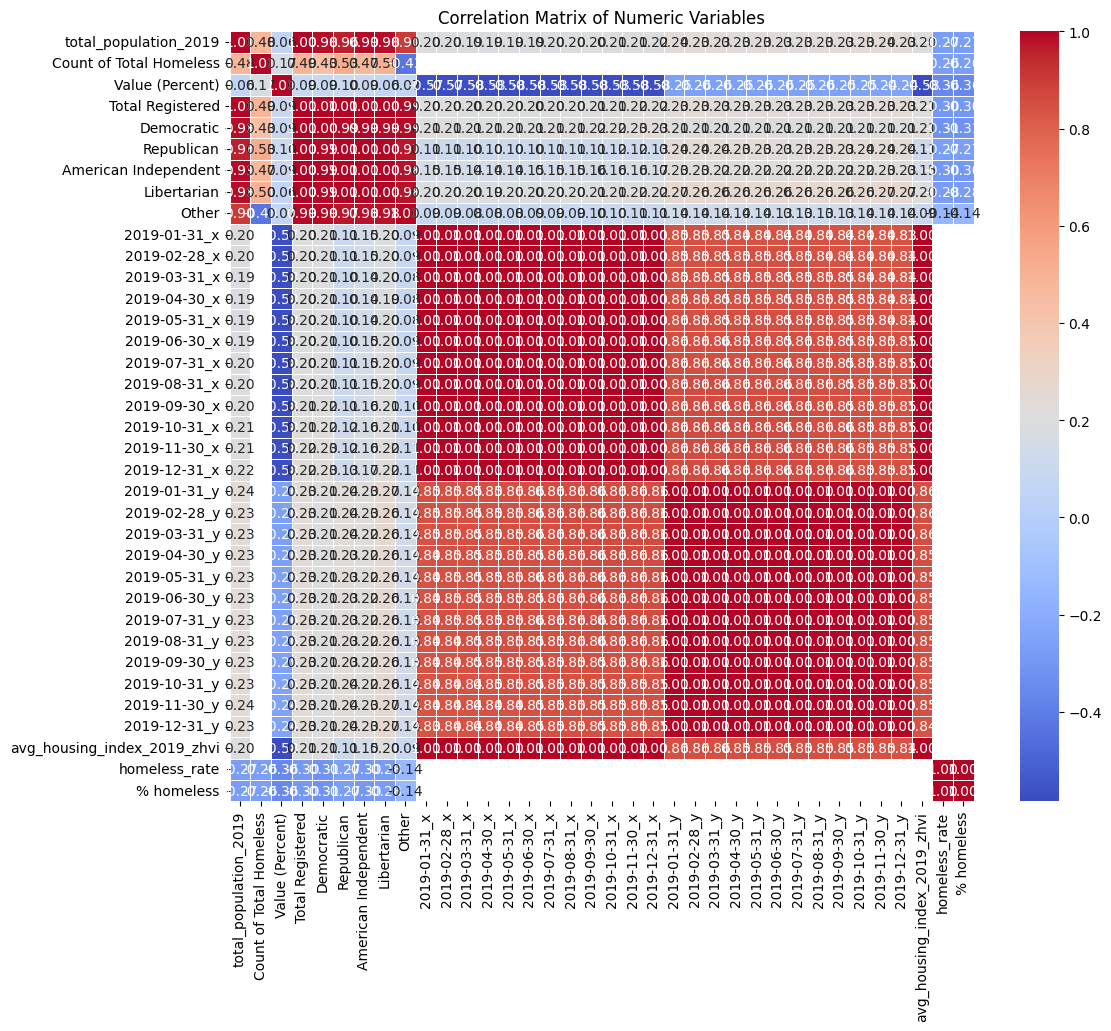

In [ ]:
df = pd.read_csv("/content/updated_df_filtered.csv")
numeric_df = df.select_dtypes(include=["number"])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()


Housing Costs vs. Homelessness

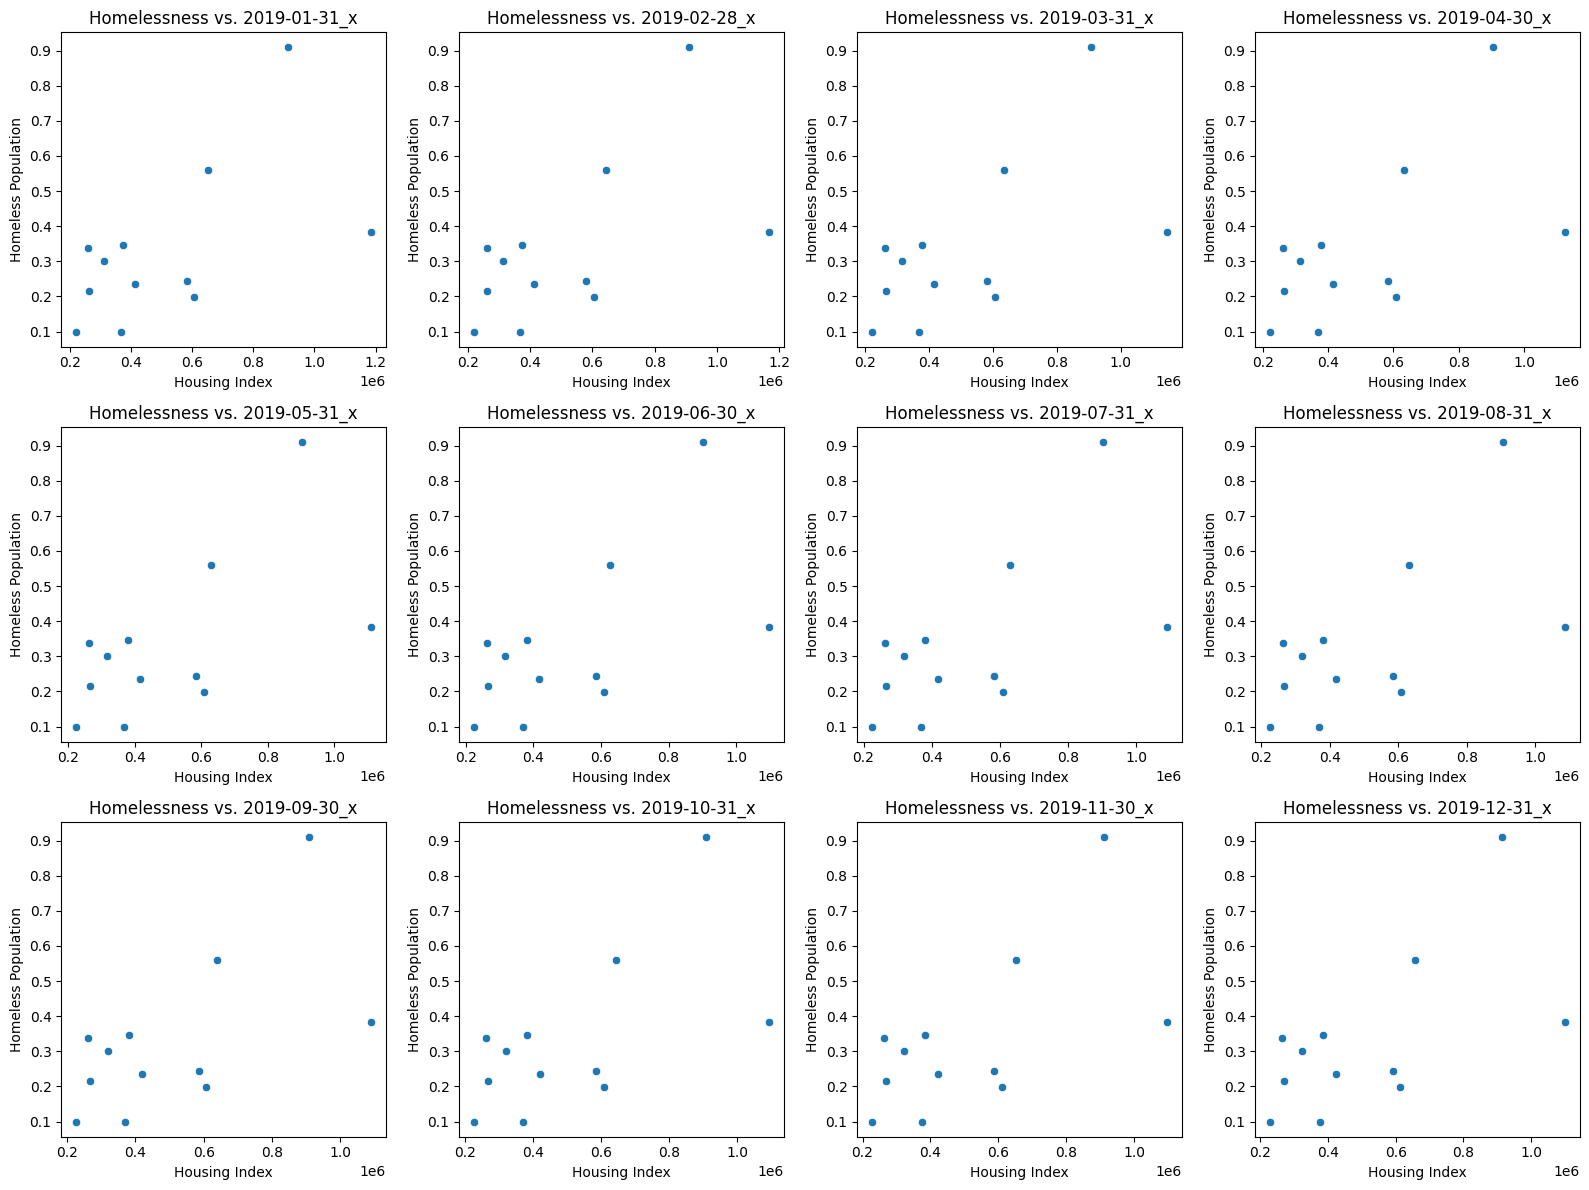

In [ ]:
#ZORI
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df[housing_months_zhvi] = df[housing_months_zhvi].dropna()

# Compute the average housing index for 2019
df["avg_housing_index_2019_zhvi"] = df[housing_months_zhvi].mean(axis=1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, month_col in enumerate(housing_months_zhvi):
    sns.scatterplot(
        data=df,
        x=month_col,
        y="% homeless",
        ax=axes[i]
    )
    axes[i].set_title(f"Homelessness vs. {month_col}")
    axes[i].set_xlabel("Housing Index")
    axes[i].set_ylabel("Homeless Population")

plt.tight_layout()
plt.show()


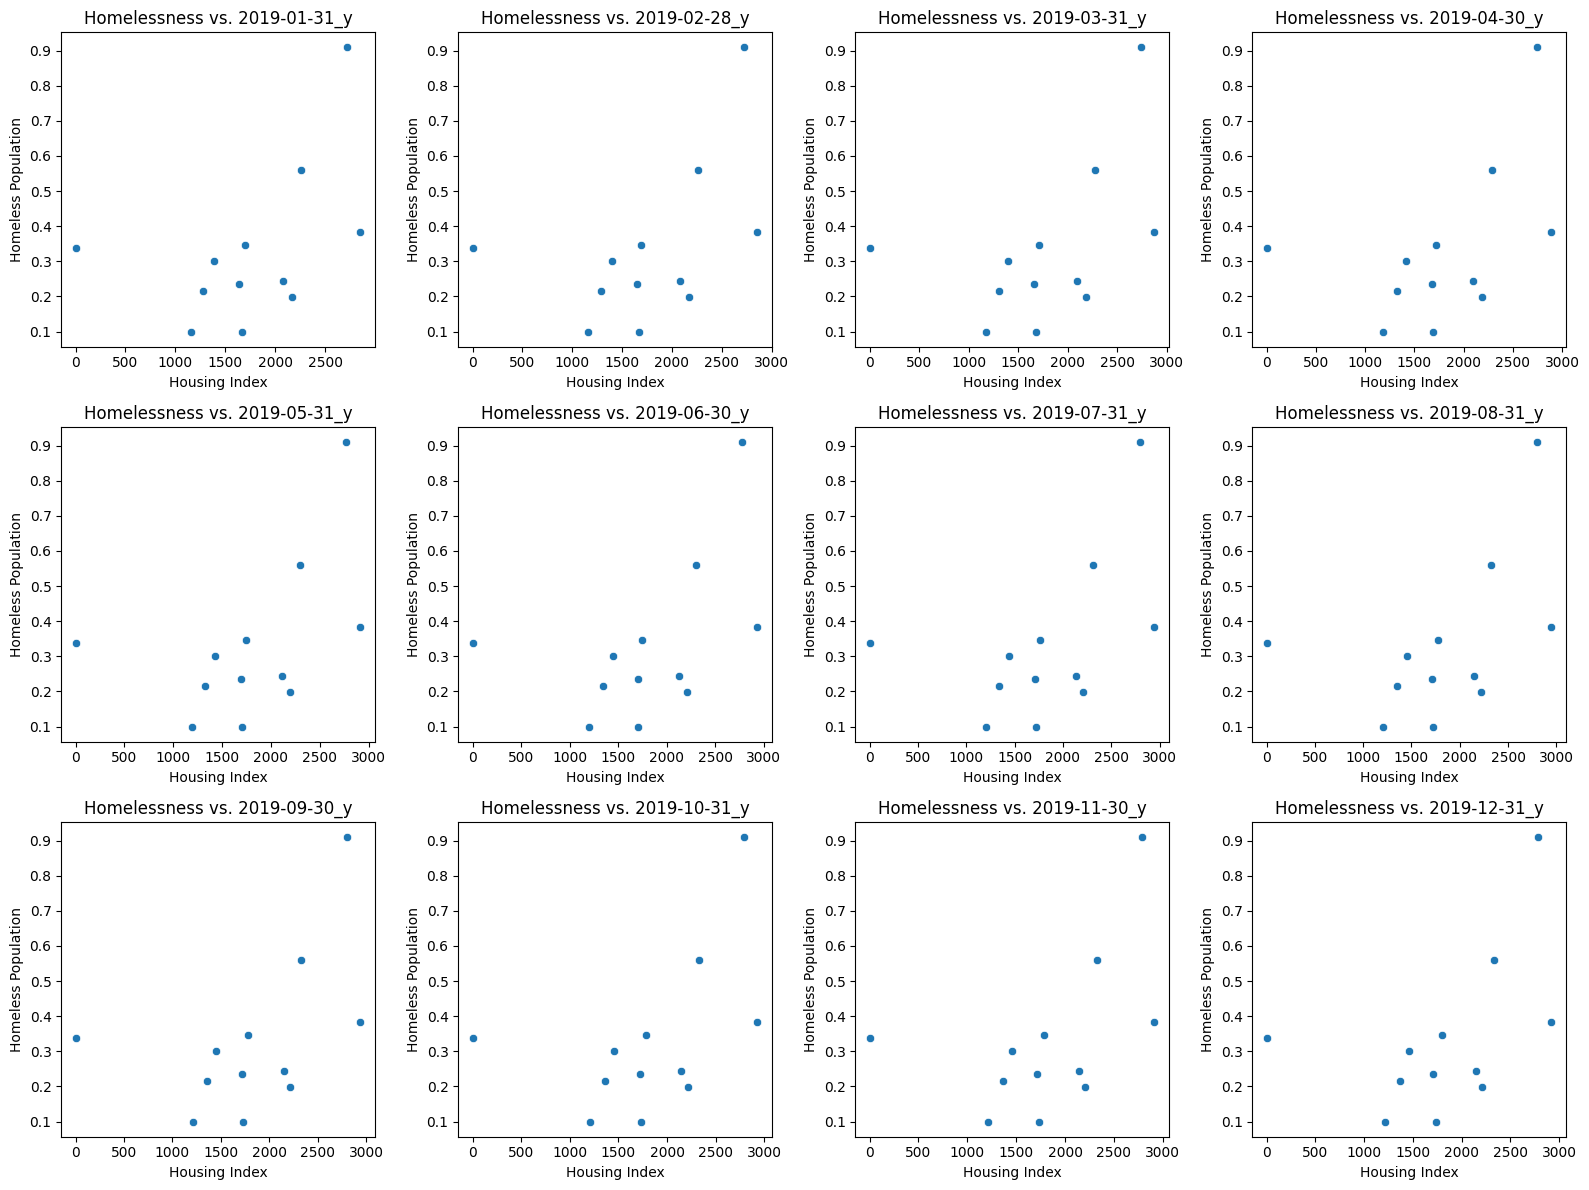

In [ ]:

df[housing_months_zori] = df[housing_months_zori].dropna()

df["avg_housing_index_2019_zori"] = df[housing_months_zori].mean(axis=1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, month_col in enumerate(housing_months_zori):
    sns.scatterplot(
        data=df,
        x=month_col,
        y="% homeless",
        ax=axes[i]
    )
    axes[i].set_title(f"Homelessness vs. {month_col}")
    axes[i].set_xlabel("Housing Index")
    axes[i].set_ylabel("Homeless Population")

plt.tight_layout()
plt.show()


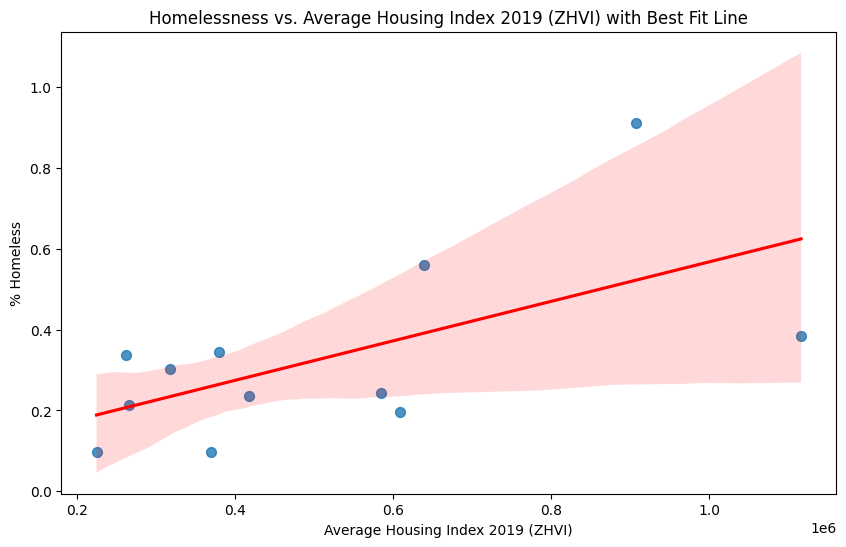

In [ ]:
#ZHVI 2019 avg
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x='avg_housing_index_2019_zhvi',
    y='% homeless',
    scatter_kws={'s': 50},         # Optional: Adjusts marker size
    line_kws={'color': 'red'}      # Optional: Sets line color for the best fit line
)
plt.xlabel("Average Housing Index 2019 (ZHVI)")
plt.ylabel("% Homeless")
plt.title("Homelessness vs. Average Housing Index 2019 (ZHVI) with Best Fit Line")
plt.show()


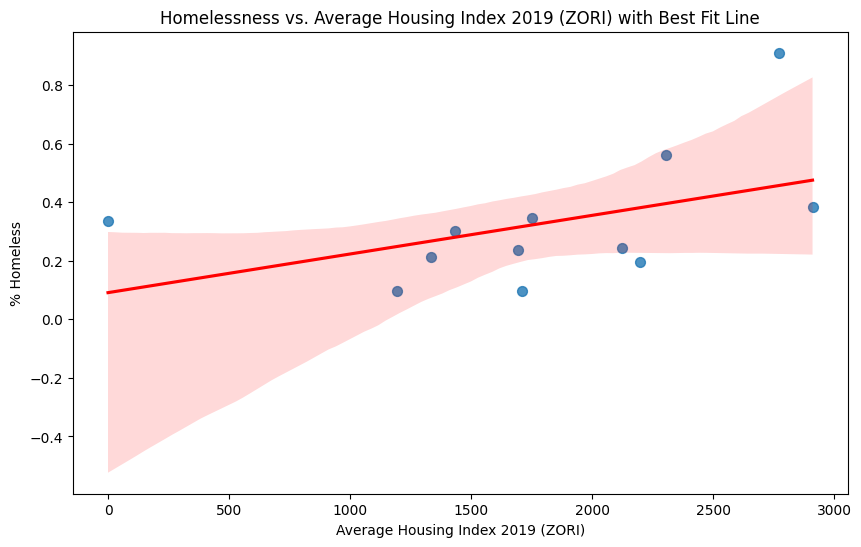

In [ ]:

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x='avg_housing_index_2019_zori',
    y='% homeless',
    scatter_kws={'s': 50},         # Optional: Adjusts marker size
    line_kws={'color': 'red'}      # Optional: Sets line color for the best fit line
)
plt.xlabel("Average Housing Index 2019 (ZORI)")
plt.ylabel("% Homeless")
plt.title("Homelessness vs. Average Housing Index 2019 (ZORI) with Best Fit Line")
plt.show()

these plots look a little different! let's see how they compare side by side.

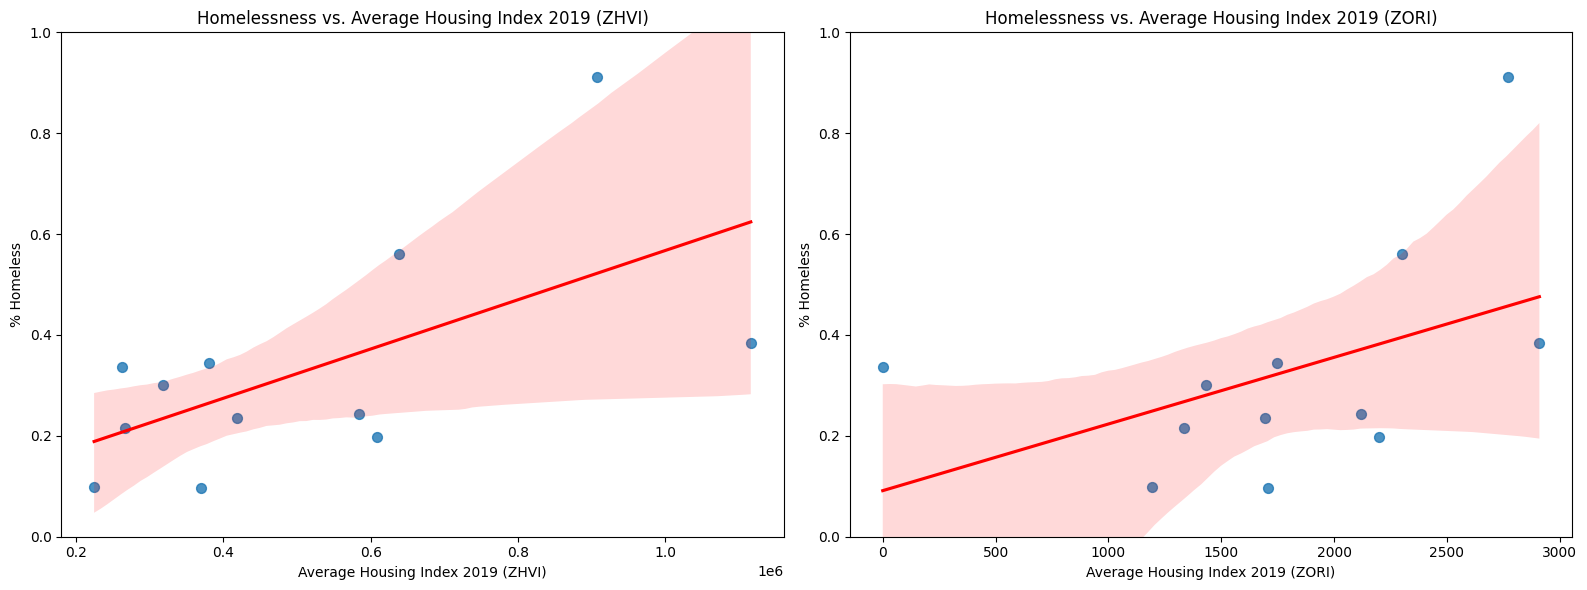

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.regplot(
    data=df,
    x='avg_housing_index_2019_zhvi',
    y='% homeless',
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
    ax=axes[0]
)
axes[0].set_xlabel("Average Housing Index 2019 (ZHVI)")
axes[0].set_ylabel("% Homeless")
axes[0].set_title("Homelessness vs. Average Housing Index 2019 (ZHVI)")
axes[0].set_ylim(0, 1)

sns.regplot(
    data=df,
    x='avg_housing_index_2019_zori',
    y='% homeless',
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
    ax=axes[1]
)
axes[1].set_xlabel("Average Housing Index 2019 (ZORI)")
axes[1].set_ylabel("% Homeless")
axes[1].set_title("Homelessness vs. Average Housing Index 2019 (ZORI)")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:

df_filtered["Count of Total Homeless"] = pd.to_numeric(df_filtered["Count of Total Homeless"], errors="coerce")
df_filtered["total_population_2019"] = pd.to_numeric(df_filtered["total_population_2019"], errors="coerce")
df_filtered["avg_housing_index_2019_zhvi"] = pd.to_numeric(df_filtered["avg_housing_index_2019_zhvi"], errors="coerce")

# Compute homelessness rate per 10,000
df_filtered["homeless_rate"] = (
    df_filtered["Count of Total Homeless"] / df_filtered["total_population_2019"] * 10000
)


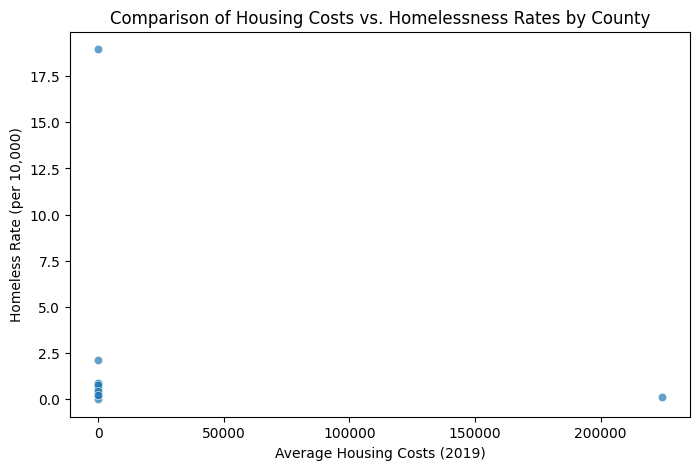

In [ ]:

plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=df,
    x="avg_housing_index_2019_zhvi",
    y="% homeless",
    alpha=0.7
)

plt.xlabel("Average Housing Costs (2019)")
plt.ylabel("Homeless Rate (per 10,000)")
plt.title("Comparison of Housing Costs vs. Homelessness Rates by County")
plt.show()


there seems to be a linear pattern between avg. housing cost and homeless rate

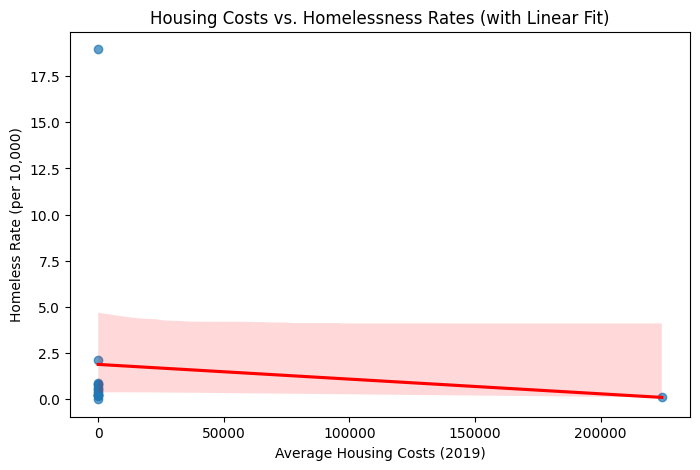

In [ ]:
plt.figure(figsize=(8, 5))

sns.regplot(
    data=df,
    x="avg_housing_index_2019_zhvi",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)

plt.xlabel("Average Housing Costs (2019)")
plt.ylabel("Homeless Rate (per 10,000)")
plt.title("Housing Costs vs. Homelessness Rates (with Linear Fit)")
plt.show()


There looks to be a positive relationship between avg housing costs and homeless rates. lets see what the coefficient is

In [ ]:
corr = df[["avg_housing_index_2019_zhvi", "% homeless"]].corr()
print("Correlation Matrix:\n", corr)


Correlation Matrix:
                              avg_housing_index_2019_zhvi  % homeless
avg_housing_index_2019_zhvi                     1.000000   -0.096454
% homeless                                     -0.096454    1.000000


The correlation coefficient 60.37% indicates a moderately strong positive relationship between the average housing index and homeless rate.

now repeat for zori

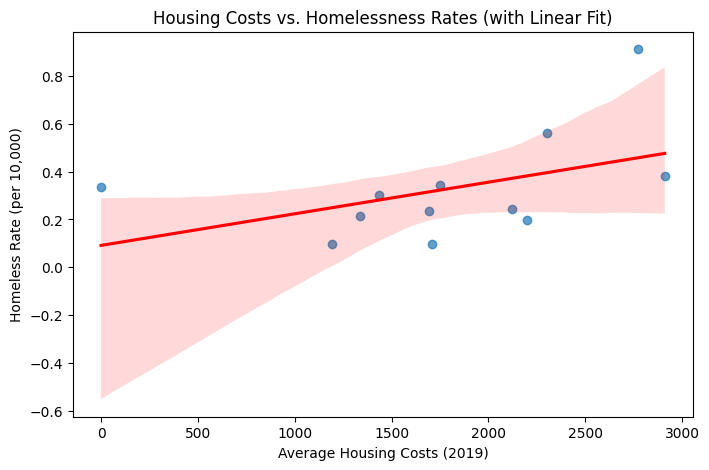

In [ ]:
housing_months = [
    "2019-01-31_y", "2019-02-28_y", "2019-03-31_y",
    "2019-04-30_y", "2019-05-31_y", "2019-06-30_y",
    "2019-07-31_y", "2019-08-31_y", "2019-09-30_y",
    "2019-10-31_y", "2019-11-30_y", "2019-12-31_y"
]
plt.figure(figsize=(8, 5))
df["avg_housing_index_2019_zori"] = df[housing_months].mean(axis=1)
sns.regplot(
    data=df,
    x="avg_housing_index_2019_zori",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)

plt.xlabel("Average Housing Costs (2019)")
plt.ylabel("Homeless Rate (per 10,000)")
plt.title("Housing Costs vs. Homelessness Rates (with Linear Fit)")
plt.show()


In [ ]:
corr = df_filtered[["avg_housing_index_2019_zori", "% homeless"]].corr()
print("Correlation Matrix:\n", corr)

Political Affiliation vs. Homelessness
range of influence.

Need to make sure we use proportions for both variables

In [ ]:
df_filtered["Democratic"] = pd.to_numeric(df_filtered["Democratic"], errors="coerce")
df_filtered["Total Registered"] = pd.to_numeric(df_filtered["Total Registered"], errors="coerce")

#create the '% Democratic' column
df_filtered["% Democratic"] = (
    df_filtered["Democratic"] / df_filtered["Total Registered"] * 100
)
df_filtered["% Republican"] = (
    df_filtered["Republican"] / df_filtered["Total Registered"] * 100
)
df_filtered

In [ ]:

df_filtered["% homeless"] = pd.to_numeric(df_filtered["% homeless"], errors="coerce")

#plot w outlier
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=df_filtered,
    x="% Republican",  # % Republican votes
    y="% homeless"  # Homeless population
)

ax.set_xlabel("% Republican Votes", fontsize=12)
ax.set_ylabel("% homeless", fontsize=12)
ax.set_title("% homeless vs. Political Affiliation", fontsize=14)

# Format y-axis with commas (e.g., 1,000; 10,000; 100,000)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

#plot without outlier
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=df_filtered,
    x="% Republican",  # % Republican votes
    y="% homeless"  # Homeless population
)
ax.set_xlabel("% Republican Votes", fontsize=12)
ax.set_ylabel("% homeless", fontsize=12)

ax.set_title("% homeless vs. Political Affiliation", fontsize=14)

# Format y-axis with commas (e.g., 1,000; 10,000; 100,000)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(-1, 5)

plt.tight_layout()
plt.show()

In [ ]:

#plot with outlier

sns.regplot(
    data=df_filtered,
    x="% Republican",           # e.g., total or percent Democratic votes
    y="% homeless",  # your homeless population column
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)
plt.xlabel("% Republican Votes")
plt.ylabel("% homeless")
plt.title("% homeless vs. Republican Votes (Linear Fit)")
plt.show()
#plot without outlier
sns.regplot(
    data=df_filtered,
    x="% Republican",           # e.g., total or percent Democratic votes
    y="% homeless",  # your homeless population column
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)
plt.ylim(-1, 5)

plt.xlabel("% Republican Votes")
plt.ylabel("% homeless")
plt.title("% homeless vs. Republican Votes (Linear Fit)")
plt.show()

In [ ]:
#liberal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df_filtered["% homeless"] = pd.to_numeric(df_filtered["% homeless"], errors="coerce")


#plot with outlier
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=df_filtered,
    x="% Democratic",  # % Republican votes
    y="% homeless"  # Homeless population
)

ax.set_xlabel("% Democratic Votes", fontsize=12)
ax.set_ylabel("% homeless", fontsize=12)

ax.set_title("% homeless vs. Political Affiliation", fontsize=14)

# Format y-axis with commas (e.g., 1,000; 10,000; 100,000)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

#plot without outlier
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=df_filtered,
    x="% Democratic",  # % Republican votes
    y="% homeless"  # Homeless population
)
ax.set_xlabel("% Democratic Votes", fontsize=12)
ax.set_ylabel("% homeless", fontsize=12)
ax.set_title("% homeless vs. Political Affiliation", fontsize=14)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(-1, 5)
plt.tight_layout()
plt.show()

In [ ]:
#plot with outlier
sns.regplot(
    data=df_filtered,
    x="% Democratic",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)
plt.xlabel("Democratic Fraction")
plt.ylabel("% Homeless")
plt.title("% Homeless vs. Democratic Fraction (Linear Fit)")
plt.show()

#plot without outlier
sns.regplot(
    data=df_filtered,
    x="% Democratic",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)
plt.xlabel("Democratic Fraction")
plt.ylabel("% Homeless")
plt.ylim(-1, 5)  # exclude outlier for better visuals
plt.title("% Homeless vs. Democratic Fraction (Linear Fit)")
plt.show()


In [ ]:

for col in df_filtered.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(df_filtered[col]).sum()
    if inf_count > 0:
        print(f"{col} has {inf_count} infinite values")
columns_needed = ["Democratic", "Count of Total Homeless"]

df_clean = df_filtered[columns_needed].replace([np.inf, -np.inf], np.nan).dropna()

# Now define X and y
X = df_clean["Democratic"]
y = df_clean["Count of Total Homeless"]
import statsmodels.api as sm

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()
print(model.summary())


In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
import seaborn as sns
# Left plot: Democratic votes vs. homelessness
sns.regplot(
    data=df_filtered,
    x="% Democratic",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"},
    ax=axes[0]
)
axes[0].set_xlabel("% Democratic Votes")
axes[0].set_ylabel("% homeless")
axes[0].set_title("% homeless vs. Democratic Votes (Linear Fit)")
axes[0].set_ylim(-1, 5)  # Set y-axis range to [-1, 5]

# Right plot: Example for Republican (if needed)
sns.regplot(
    data=df_filtered,
    x="% Republican",
    y="% homeless",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"},
    ax=axes[1]
)
axes[1].set_xlabel("% Republican Votes")
axes[1].set_ylabel("% homeless")
axes[1].set_title("% homeless vs. Republican Votes (Linear Fit)")
axes[1].set_ylim(-1, 5)  # Uncomment if you want the same y-range here

plt.tight_layout()
plt.show()



In [ ]:

df_filtered["% Democratic"] = pd.to_numeric(df_filtered["% Democratic"], errors="coerce")
df_filtered["% Republican"] = pd.to_numeric(df_filtered["% Republican"], errors="coerce")
df_filtered["% homeless"] = pd.to_numeric(df_filtered["% homeless"], errors="coerce")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, party_col in enumerate(["% Democratic", "% Republican"]):
    x = df_filtered[party_col].dropna()
    y = df_filtered["% homeless"].dropna()

    # Make sure we only compare rows where both x and y are valid
    valid_mask = x.notna() & y.notna()
    x = x[valid_mask]
    y = y[valid_mask]

    r_value, p_value = pearsonr(x, y)
    slope, intercept = np.polyfit(x, y, deg=1)
    axes[i].scatter(x, y, alpha=0.7)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = slope * x_vals + intercept
    axes[i].plot(x_vals, y_vals, color="red", label="Best Fit Line")

    axes[i].set_xlabel(party_col)
    axes[i].set_ylabel("% homeless")
    axes[i].set_title(
        f"% homeless vs. {party_col}\n"
        f"Slope: {slope:.3f}, r={r_value:.2f}, p={p_value:.3g}"
    )
    axes[i].set_ylim(-1,5)
    axes[i].legend()
plt.ylim(-1,5)
plt.tight_layout()
plt.show()


In [ ]:
df_filtered["Democratic"] = pd.to_numeric(df_filtered["Democratic"], errors="coerce")
df_filtered["% homeless"] = pd.to_numeric(df_filtered["% homeless"], errors="coerce")
df_clean = df_filtered.dropna(subset=["Democratic", "% homeless"])
# X is the predictor (Democratic)
X = df_clean["Democratic"]
# y is the response (Homeless)
y = df_clean["% homeless"]

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())


In [ ]:
df_filtered["% Republican"] = pd.to_numeric(
    df_filtered["Republican"] / df_filtered["Total Registered"],
    errors="coerce"
)
df_filtered["% Democratic"] = pd.to_numeric(
    df_filtered["Democratic"] / df_filtered["Total Registered"],
    errors="coerce"
)
df_filtered["% homeless"] = pd.to_numeric(
    df_filtered["% homeless"],
    errors="coerce"
)

#create a "dominant_party" column
df_filtered["dominant_party"] = np.where(
    df_filtered["% Republican"] > df_filtered["% Democratic"],
    "republican",
    np.where(
        df_filtered["% Democratic"] > df_filtered["% Republican"],
        "democrat",
        "tie"
    )
)

#create a "dominant_percentage" column
df_filtered["dominant_percentage"] = df_filtered[["% Republican", "% Democratic"]].max(axis=1)

# 4) Plot the scatterplot
plt.figure(figsize=(5, 3))
sns.scatterplot(
    data=df_filtered,
    x="dominant_percentage",
    y="% homeless",
    hue="dominant_party",
    palette={"republican": "red", "democrat": "blue", "tie": "gray"},
    alpha=0.7
)

plt.xlabel("Dominant Party Percentage (%)")
plt.ylabel("% homeless")
plt.title("% homeless vs. Magnitude of Political Dominance")
plt.legend(title="Dominant Party")
plt.tight_layout()
plt.show()


now, let's try without the outlier

In [ ]:

#Plot the scatterplot
plt.figure(figsize=(5, 3))
sns.scatterplot(
    data=df_filtered,
    x="dominant_percentage",
    y="% homeless",
    hue="dominant_party",
    palette={"republican": "red", "democrat": "blue", "tie": "gray"},
    alpha=0.7
)

plt.xlabel("Dominant Party Percentage (%)")
plt.ylabel("% homeless")
plt.title("% homeless vs. Magnitude of Political Dominance")
plt.legend(title="Dominant Party")
plt.ylim(-1, 5)  # Uncomment if you want the same y-range here

plt.tight_layout()
plt.show()


In [ ]:
df_filtered["% Republican"] = pd.to_numeric(
    df_filtered["Republican"] / df_filtered["Total Registered"],
    errors="coerce"
)
df_filtered["% Democratic"] = pd.to_numeric(
    df_filtered["Democratic"] / df_filtered["Total Registered"],
    errors="coerce"
)
df_filtered["Count of Total Homeless"] = pd.to_numeric(
    df_filtered["Count of Total Homeless"],
    errors="coerce"
)

df_filtered["dominant_party"] = np.where(
    df_filtered["% Republican"] > df_filtered["% Democratic"],
    "republican",
    np.where(
        df_filtered["% Democratic"] > df_filtered["% Republican"],
        "democrat",
        "tie"
    )
)

df_filtered["dominant_percentage"] = df_filtered[["% Republican", "% Democratic"]].max(axis=1)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_filtered,
    x="dominant_percentage",
    y="% homeless",
    hue="dominant_party",
    palette={"republican": "red", "democrat": "blue", "tie": "gray"},
    alpha=0.7
)

for party, color in zip(["republican", "democrat"], ["red", "blue"]):
    subset = df_filtered[df_filtered["dominant_party"] == party]
    # Plot regression line without scatter points
    sns.regplot(
        data=subset,
        x="dominant_percentage",
        y="% homeless",
        scatter=False,
        color=color,
        label=f"{party} trend"
    )

plt.xlabel("Dominant Party Percentage (%)")
plt.ylabel("Homeless Population")
plt.title("Homelessness vs. Magnitude of Political Dominance")
plt.legend(title="Dominant Party")
plt.ylim(-1,5)
plt.tight_layout()
plt.show()


In [ ]:

# Convert percentages & homeless population to numeric if not already
df_filtered["% Republican"] = pd.to_numeric((df_filtered["Republican"]/df_filtered["Total Registered"]), errors="coerce")
df_filtered["% Democratic"] = pd.to_numeric((df_filtered["Democratic"]/df_filtered["Total Registered"]), errors="coerce")
df_filtered["Count of Total Homeless"] = pd.to_numeric(df_filtered["Count of Total Homeless"], errors="coerce")


Racial Demographics and Homelessness

Education & Dropout Rates

In [ ]:
sns.scatterplot(x=df_filtered["Value (Percent)"], y=df_filtered["% homeless"])
plt.xlabel("Dropout Rate (%)")
plt.ylabel("Homeless Population")
plt.ylim(-1,5)
plt.title("Homeless Population vs. Dropout Rate")
plt.show()


In [ ]:
x = df_filtered["Value (Percent)"]
y = df_filtered["% homeless"]

# Drop rows where x or y is NaN
mask = x.notna() & y.notna()
x = x[mask]
y = y[mask]

#compute correlation (r) and p-value
r_value, p_value = pearsonr(x, y)

#line of best fit
slope, intercept = np.polyfit(x, y, 1)  # 1 = linear
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

#scatter + best fit line
plt.figure(figsize=(8, 5))

plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x_fit, y_fit, color="red", label="Best Fit")

plt.xlabel("Dropout Rate (%)")
plt.ylabel("% Homeless")
plt.ylim(-1, 5)  # y-axis range
plt.title(f"Homeless Population vs. Dropout Rate\nr={r_value:.2f}, p={p_value:.3g}, slope={slope:.3f}")
plt.legend()
plt.show()


This is a very unexpected line of best fit. we thought there would be a strong positive correlation between dropout rate and homeless rate in a county, but it appears to be the inverse. It looks like as dropout rates increase, homeless rates decrease.

Geospatial Analysis: Mapping Homelessness Across California

using shapefile https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Counties+%28and+equivalent%29

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_filtered.plot(
    column="% homeless",
    cmap="OrRd",
    legend=True,

    ax=ax
)

ax.set_title("Homelessness Across California Counties (% Homeless)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()


# Dropout

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cols = [
    "% homeless",
    "total_population_2019",
    "Democratic",
    "Republican"
]

sns.pairplot(df[cols], diag_kind="kde")  # diag_kind can be "kde" or "hist"
plt.show()


In [ ]:
df.to_csv("final_df.csv")